In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure as fig
import skimage
from skimage import io, color
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
from skimage import data, filters
from ipywidgets import widgets
from scipy.ndimage import convolve
from skimage import exposure
from skimage.filters import threshold_mean


%matplotlib inline

    
def display_with_histogram(image, title):
    # pega parâmetros da imagem
    channels = image.shape[2] if len(image.shape) > 2 else 1
    is_colored = channels > 1

    # cria uma figura com espaço para a imagem e para o histograma
    figure, axes = plt.subplots(1, 2, figsize=(18, 5))
    image_axis, histogram_axis = axes

    # coloca a imagem em seu subplot
    image_axis.imshow(image, cmap='gray')
    image_axis.set_axis_off()
    image_axis.set_title('{} {}'.format(title, image.shape))

    # coloca o histograma em seu subplot
    if is_colored:
        channel_colors = ['red', 'green', 'blue']
        for i, c in enumerate(channel_colors):
            histogram_axis.hist(image[:, :, i].flatten(), bins=256, lw=1, color=c, histtype='step')
    else:
        histogram_axis.hist(image.ravel(), bins=256, lw=0, histtype='bar')
    histogram_axis.set_xlim(0, image.max())
    histogram_axis.set_yticks([])

    plt.show()


def display_all_images(images):
    # cria uma figura com espaço todas as imagens
    figure, axes = plt.subplots(2, 3, figsize=(18, 8))

    axes = axes.ravel()
    
    # coloca a imagem em seu subplot
    for i, image in enumerate(images):
        ax = axes[i]
        ax.imshow(image[1])
        ax.set_axis_off()
        ax.set_title(images[i][0])
        ax.plot()

    plt.show()
    

def display(title, image, full=False):
    size = (18,12) if full else (12,6)
    figure, axes = plt.subplots(num=1, figsize=size)
    axes.axis('off')
    axes.set_title('{} {}'.format(title, image.shape))
    axes.imshow(image)
    plt.show()
    
def display_two_images(left, right, title=''):
    figure, axes = plt.subplots(1, 2, figsize=size)
    left_ax, right_ax = axes

    left_ax.imshow(left)
    right_ax.imshow(right)
    
    left_ax.set_axis_off()
    right_ax.set_axis_off()
    
    plt.show()

## Imagens originais

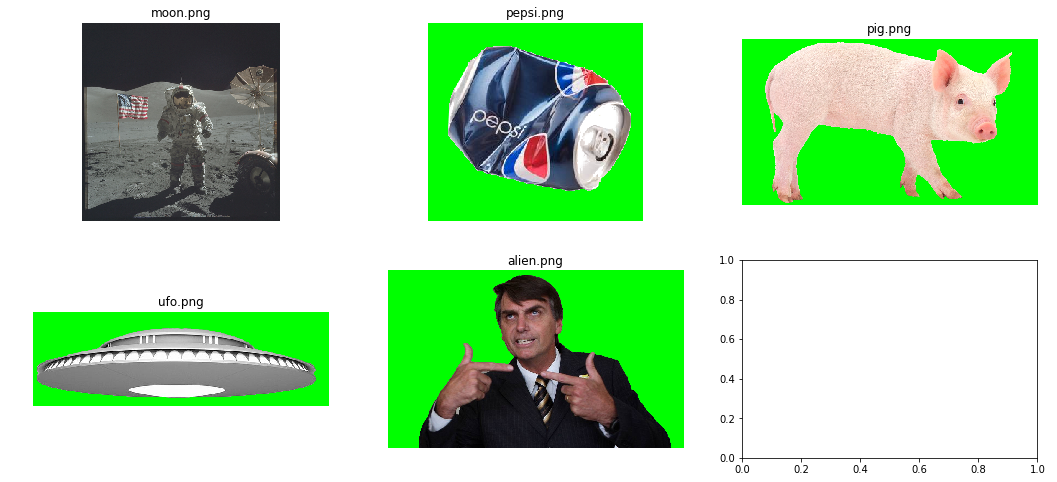

In [24]:
moon = skimage.img_as_float(io.imread("imagens/moon.png"))
pepsi = skimage.img_as_float(io.imread("imagens/pepsi.png"))
pig = skimage.img_as_float(io.imread("imagens/pig.png"))
ufo = skimage.img_as_float(io.imread("imagens/ufo.png"))
alien = skimage.img_as_float(io.imread("imagens/alien.png"))

display_all_images([
    ('moon.png', moon), 
    ('pepsi.png', pepsi),
    ('pig.png', pig),
    ('ufo.png', ufo),
    ('alien.png', alien)
])

## _Chroma keying_

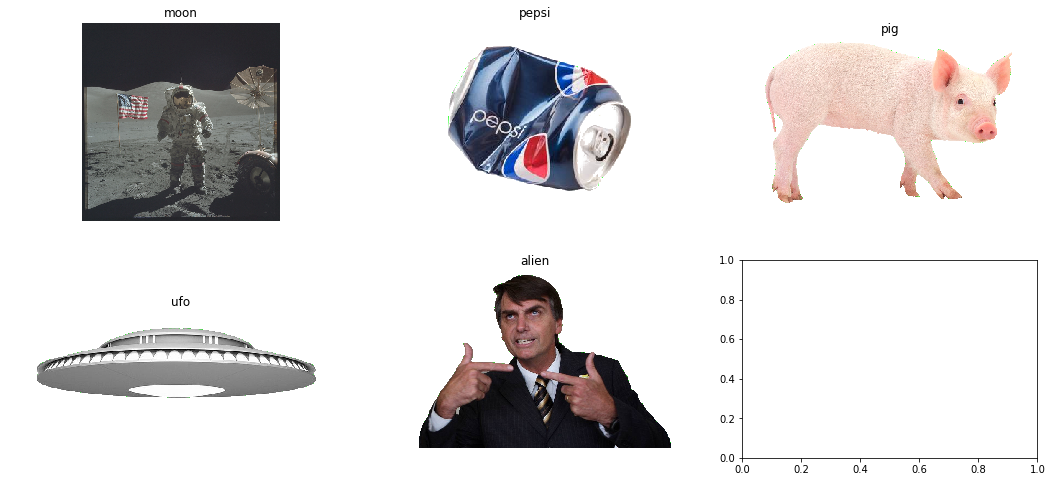

In [25]:
import numpy.ma as ma

def color_to_transparency(image, color, tolerance=0.25):
    '''
    Substitui uma cor da imagem RGBA por transparência.
    É utilizada uma tolerência de 25% em cada canal por padrão.
    '''
    masked_image = image.copy()
  
    reds = masked_image[:, :, 0]
    greens = masked_image[:, :, 1]
    blues = masked_image[:, :, 2]
    
    masked_reds = ma.masked_values(reds, color[0], atol=tolerance)
    masked_greens = ma.masked_values(greens, color[1], atol=tolerance)
    masked_blues = ma.masked_values(blues, color[2], atol=tolerance)
    masked_image[masked_reds.mask & masked_greens.mask & masked_blues.mask] = 0
    
    return masked_image



# tira o fundo das imagens
pepsi_transparent = color_to_transparency(pepsi, [0, 1, 0])
pig_transparent = color_to_transparency(pig, [0, 1, 0])
ufo_transparent = color_to_transparency(ufo, [0, 1, 0])
alien_transparent = color_to_transparency(alien, [0, 1, 0])


# mostra o resultado
display_all_images([
    ('moon', moon),
    ('pepsi', pepsi_transparent),
    ('pig', pig_transparent),
    ('ufo', ufo_transparent),
    ('alien', alien_transparent),
])

## Mesclagem de imagens

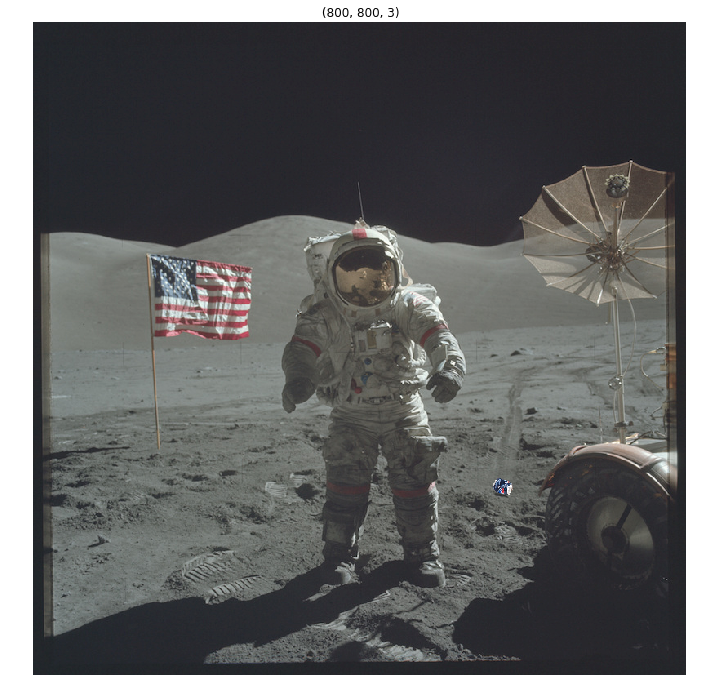

In [29]:
from skimage.transform import resize
from skimage import color

def merge_images(background, image, position=(0,0), scale=(1,1)):
    # pega as dimensões da imagem de fundo e da que será colada
    background_height, background_width, channels = background.shape
    image_height, image_width = np.floor(np.array(image.shape[:2]) * np.array(scale)).astype(int)
    
    # redimensiona a imagem para seu devido lugar
    image_resized = resize(image.copy(), (image_height, image_width), mode='constant')
    
    # cria uma imagem do tamanho do background, mas com 0s
    new_image = np.zeros((background_height, background_width, channels))
    # cola a imagem no lugar
    y = position[0]
    x = position[1]
    new_image[y : y+image_height, x : x+image_width, :] = image_resized
    
    # cria máscara
    mask = np.stack([new_image[:, :, 3] for _ in range(3)], axis=2)
    inv_mask = 1 - mask
    
    # mesclagem final
    return background[:, :, :3] * inv_mask + new_image[:, :, :3] * mask


merged = merge_images(moon, pepsi_transparent, (556,561), (0.1, 0.1))
display('', merged, True)

In [37]:
def desaturate(image, amount):
    only_rgb = image[:, :, :3]
    to_hsv = color.rgb2hsv(only_rgb)
    
    # faz a dessaturação
    to_hsv[:, 1, :] *= amount
    
    # converte de volta para rgb, depois rgba
    only_rgb = color.hsv2rgb(to_hsv)
    print(only_rgb.shape)
    print('ERRO AQUI!!')
    desaturated_image = np.reshape(only_rgb, image.shape)
    print(desaturated_image.shape)
    desaturated_image[..., 3] = image[..., 3]

    return desaturated_image

pepsi_colored = desaturate(pepsi_transparent, 0.5)
display('Pepsi desaturated', pepsi_colored)

(276, 299, 3)
ERRO AQUI!!


ValueError: cannot reshape array of size 247572 into shape (276,299,4)